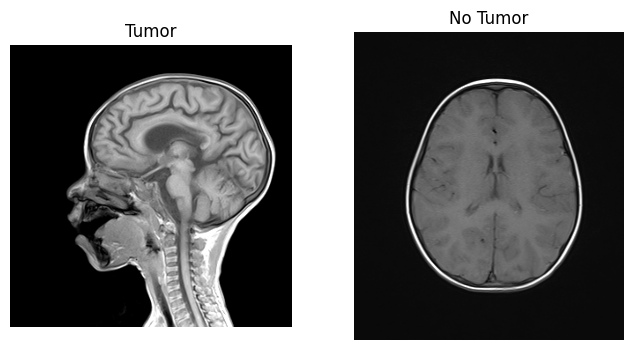

In [103]:
# Load and visualize images from YES and NO folders

import os
import matplotlib.pyplot as plt
import random
import keras
import tensorflow
from PIL import Image
from tensorflow.keras import optimizers,callbacks
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import pandas as pd

yes_dir = "/kaggle/input/tumor-classes/YES/YES"
no_dir = "/kaggle/input/tumor-classes/NO/NO"

# Collect file names
yes_imgs = [f for f in os.listdir(yes_dir) if f.lower().endswith(('.png','.jpg','.jpeg','.bmp'))]
no_imgs = [f for f in os.listdir(no_dir) if f.lower().endswith(('.png','.jpg','.jpeg','.bmp'))]

# HALF of YES images (randomly sampled)
# half_yes = random.sample(yes_imgs, len(yes_imgs)//2)
yes_paths = [os.path.join(yes_dir, f) for f in yes_imgs]
no_paths = [os.path.join(no_dir, f) for f in no_imgs]
all_paths = yes_paths + no_paths
all_labels = ['YES']*len(yes_paths) + ['NO']*len(no_paths)

df = pd.DataFrame({'filename': all_paths, 'class': all_labels})

# FULL set of NO images

#each class
plt.figure(figsize=(8,4))
for i, folder in enumerate([yes_dir, no_dir]):
    img_name = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_name)
    img = Image.open(img_path)
    plt.subplot(1,2,i+1)
    plt.imshow(img)
    plt.title("Tumor" if i==0 else "No Tumor")
    plt.axis('off')
plt.show()

In [107]:
#HYPERPARAMETERS SECTION
configurations={
    "epochs": 10,
    # "fine_tune_layers": 20,  # Number of top layers to unfreeze during fine-tuning
    "batch_size": 32,        # for mini batch gradient descent
    "learning_rate": 0.00005, # for all layers, you can also set it per layer from create_model function.
    "image_size": (150,150),

    "val_split": 0.15,        # Validation split ratio
    # "dropout_rate": 0.4,      # Dropout rate for classifier layers
    "l2_reg": 10*1e-5,          # L2 regularization strength for each layer, or you can individually set it per layer from create_model function.

    "use_augmentation": True, # switch for data augmentation enabling.
    "rotation_range": 0.15,    # Random rotation factor
    "zoom_range": 0.15,        # Random zoom factor
    "flip_horizontal": True,  # Enable horizontal flipping

    "Training Control": True,  # switch for training control callbacks enabling. simple application of early stopping, learning rate reduction and model checkpointing.
    "early_stopping_patience": 10,   # Epochs to wait before early stopping
    "lr_reduction_patience": 2,     # Epochs to wait before reducing LR
    "lr_reduction_factor": 0.2,     # Factor to reduce LR by
    "min_lr": 1e-8,                 # Minimum learning rate
}
  # Change to (224, 224) or any size you want. 256^2 is minimum for accurate prognosis 
#of very small lesions/tumors aswell.
batch_size = configurations["batch_size"]
img_size = configurations["image_size"]

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=configurations["val_split"], stratify=df['class'], random_state=42)


val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    class_mode='binary',
    target_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    class_mode='binary',
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

callbacks_list=[]
if configurations['Training Control']==True:
  checkpoint_file = 'best_model.keras'
  callbacks_list.extend([
          callbacks.EarlyStopping(
              monitor='val_accuracy',
              patience=configurations["early_stopping_patience"],
              restore_best_weights=True,
              min_delta=0.001,
              verbose=1
          ),
          callbacks.ReduceLROnPlateau(
              monitor='val_loss',
              factor=configurations["lr_reduction_factor"],
              patience=configurations["lr_reduction_patience"],
              min_lr=configurations["min_lr"],
              verbose=1
          ),
          callbacks.ModelCheckpoint(
              checkpoint_file,
              monitor='val_accuracy',
              save_best_only=True,
              mode='max',
              verbose=1)])

Found 4459 validated image filenames belonging to 2 classes.
Found 788 validated image filenames belonging to 2 classes.


In [86]:
# ARCHITECTURE SECTION
from tensorflow.keras import Sequential,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomFlip, RandomRotation

# Create the input shape tuple (height, width, channels)
input_shape = configurations["image_size"] + (3,)

model = Sequential([#Reinitializes model
    Input(shape=input_shape),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    # Dropout(0.3),  # slight regularization
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # binary output
])


In [108]:
from tensorflow.keras import optimizers
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


model.compile(optimizer=optimizers.Adam(configurations['learning_rate']),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_gen,
    validation_data=val_gen,
    # Use the batch_size variable from the data generator definition
    batch_size=batch_size,
    epochs=configurations["epochs"],
    callbacks=callbacks_list
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9572 - loss: 0.1069
Epoch 2: val_accuracy improved from 0.91624 to 0.93020, saving model to best_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 33s 239ms/step - accuracy: 0.9572 - loss: 0.1069 - val_accuracy: 0.9302 - val_loss: 0.2203 - learning_rate: 5.0000e-05
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9611 - loss: 0.0938
Epoch 3: val_accuracy did not improve from 0.93020
140/140 ━━━━━━━━━━━━━━━━━━━━ 33s 237ms/step - accuracy: 0.9610 - loss: 0.0939 - val_accuracy: 0.9239 - val_loss: 0.2148 - learning_rate: 5.0000e-05
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9645 - loss: 0.0976
Epoch 4: val_accuracy did not improve from 0.93020
140/140 ━━━━━━━━━━━━━━━━━━━━ 33s 237ms/step - accuracy: 0.9645 - loss: 0.0976 - val_accuracy: 0.9264 - val_loss: 0.2188 - learning_rate: 5.0000e-05
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9689 - loss: 0.0854
Epoch 5: val_

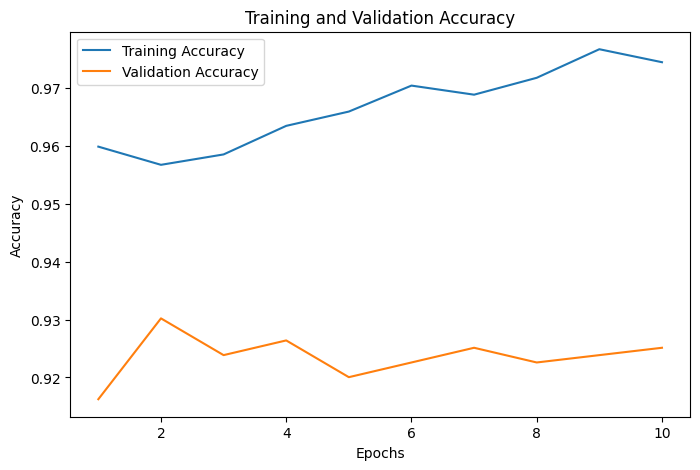

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
True Labels (Numerical):
[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]

Predicted Probabilities (Sigmoid Output - Truncated to 2 Decimals):
[0.44, 0.0, 1.0, 0.19, 1.0, 0.07, 1.0, 0.05, 0.99, 1.0]


In [109]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Get a batch and select 10 samples
sample_batch = next(val_gen)
sample_images = sample_batch[0][:10]
sample_true_labels = sample_batch[1][:10]
predictions = model.predict(sample_images)
truncated_predictions = [round(p, 2) for p in predictions.flatten().tolist()]
print("True Labels (Numerical):")
print(sample_true_labels.tolist())
print("\nPredicted Probabilities (Sigmoid Output - Truncated to 2 Decimals):")
print(truncated_predictions)

In [83]:
print("Model Summary:")
model.summary()


Model Summary:


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,057,665 (4.03 MB)

 Trainable params: 1,056,961 (4.03 MB)

 Non-trainable params: 704 (2.75 KB)